In [86]:
%matplotlib inline
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
from skimage import io, transform
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

In [94]:
#Create Folder Paths to shorten directory
landmark = Path('''E:\Data_Cloud\GoogleDrive\Thinkful\CapstoneIV\Dataset\Landmark''')
wild = Path('''E:\Data_Cloud\GoogleDrive\Thinkful\CapstoneIV\Dataset\wild''')
crop_utkface = Path('''E:\Data_Cloud\GoogleDrive\Thinkful\CapstoneIV\Dataset\Crop''')

In [101]:
landmark1 = pd.read_csv(landmark/'landmark_list_part1.txt',header=None)
landmark2 = pd.read_csv(landmark/'landmark_list_part2.txt', header=None)
landmark3 = pd.read_csv(landmark/'landmark_list_part3.txt',header=None)

landmark_frame = pd.concat([landmark1, landmark2, landmark3])

In [102]:
wild1 = pd.read_csv(wild/'landmark_list_part1.txt',header=None)
wild2 = pd.read_csv(wild/'landmark_list_part2.txt',header=None)
wild3 = pd.read_csv(wild/'landmark_list_part3.txt',header=None)

wild_frame = pd.concat([wild1, wild2, wild3])

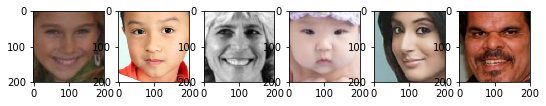

In [103]:
plt.figure(figsize=(15,15))

crop_folder = crop_utkface/'crop_part1'

for i in range(6):
    file = np.random.choice(os.listdir(crop_folder))
    image_path= os.path.join(crop_folder, file)
    image=mpimg.imread(image_path)
    plt.subplot(1,10,i+1)
    plt.imshow(image)

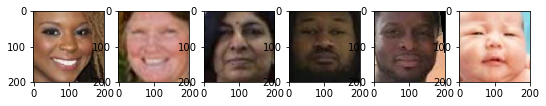

In [104]:
plt.figure(figsize=(15,15))

UTKFace_folder = crop_utkface/'UTKFace'

for i in range(6):
    file = np.random.choice(os.listdir(UTKFace_folder))
    image_path = os.path.join(UTKFace_folder, file)
    image=mpimg.imread(image_path)
    plt.subplot(1,10,i+1)
    plt.imshow(image)

In [121]:
mpimg.imread('E:\Data_Cloud\GoogleDrive\Thinkful\CapstoneIV\Dataset\Crop\crop_part1')


PermissionError: [Errno 13] Permission denied: 'E:\\Data_Cloud\\GoogleDrive\\Thinkful\\CapstoneIV\\Dataset\\Crop\\crop_part1'

In [ ]:
DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

In [67]:
#Creata Data Loader
class GetDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)
        
    def __len__(self):
        return len(self.total_imgs)
    
    def __getitem__(self, index):
        img_loc = os.path.join(self.main_dir, self.total_imgs[index])
        image = Image.open(img_loc).convert('rbg')
        tensor_image = self.transform(image)
        return tensor_image

In [68]:
trnsfrm = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor()]) 

In [69]:
GetDataset.mro

<function GetDataset.mro()>

In [32]:
imagenet = torchvision.datasets.ImageNet('E:\Data_Cloud\GoogleDrive\Thinkful\CapstoneIV\Dataset\Crop\crop_part1')
data_loader = torch.utils.data.DataLoader(imagenet,
                                          batch_size=4,
                                          shuffle=True)

RuntimeError: The archive ILSVRC2012_devkit_t12.tar.gz is not present in the root directory or is corrupted. You need to download it externally and place it in E:\Data_Cloud\GoogleDrive\Thinkful\CapstoneIV\Dataset\Crop\crop_part1.

In [77]:
train_loader = Dataloader(faces_df, batch_size=4, shuffle=False,
                               num_workers=4, drop_last=True)

NameError: name 'Dataloader' is not defined

In [27]:
dataset = datasets.ImageFolder('E:\Data_Cloud\GoogleDrive\Thinkful\CapstoneIV\Dataset\Crop\crop_part1')

RuntimeError: Found 0 files in subfolders of: E:\Data_Cloud\GoogleDrive\Thinkful\CapstoneIV\Dataset\Crop\crop_part1
Supported extensions are: .jpg,.jpeg,.png,.ppm,.bmp,.pgm,.tif,.tiff,.webp

In [ ]:
data

In [28]:
dataset = datasets.ImageFolder('E:\Data_Cloud\GoogleDrive\Thinkful\Capstone IV, Final Capstone\Dataset\Crop\crop_part1')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:\\Data_Cloud\\GoogleDrive\\Thinkful\\Capstone IV, Final Capstone\\Dataset\\Crop\\crop_part1'

In [75]:
dataset = datasets.ImageFolder('E:\Data_Cloud\GoogleDrive\Thinkful\Capstone IV, Final Capstone\Dataset\Crop\crop_part1',
                              transform=None)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:\\Data_Cloud\\GoogleDrive\\Thinkful\\Capstone IV, Final Capstone\\Dataset\\Crop\\crop_part1'

In [74]:
dataset = datasets.ImageFolder('E:\Data_Cloud\GoogleDrive\Thinkful\Capstone IV, Final Capstone\Dataset\Crop\crop_part1',
                              transform=None)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:\\Data_Cloud\\GoogleDrive\\Thinkful\\Capstone IV, Final Capstone\\Dataset\\Crop\\crop_part1'